# Projet Fraude 



In [65]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression

### Importer les dataset

In [25]:
#target --> class : 1 Fraud | 0 ok 
data_fraud = pd.read_csv("Fraud_Data.csv")
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
data_ip = pd.read_csv("Ipaddress_to_Country.csv")
data_ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Créer une nouvelle colonne `country` en effectuant une jointure entre les deux dataset 

In [26]:
def ip2country(ip: int):
    return data_ip.loc[(data_ip['lower_bound_ip_address'] <= ip) & (ip <= data_ip['upper_bound_ip_address']), "country"].squeeze()


data_fraud["country"] = data_fraud["ip_address"].map(ip2country)


In [27]:
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,"Series([], Name: country, dtype: object)"
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Créer une nouvelle variable `time_diff` qui sera la différence entre les variables `purchase_time` et `signup_time`

In [28]:
data_fraud[['signup_time','purchase_time']] = data_fraud[['signup_time','purchase_time']].apply(pd.to_datetime)
data_fraud['time_diff'] = (data_fraud['purchase_time'] - data_fraud['signup_time']).dt.total_seconds()

In [13]:
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,"Series([], Name: country, dtype: object)",492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


### Regroupper les `user_id` par `device_id`  afin d'avoir le nombre de device par client  

In [29]:
#Different user id's using the same device
device_user_count = len(data_fraud) * [0]
device_count = data_fraud.groupby('device_id')['user_id'].count()
device_user_count = device_count[data_fraud['device_id']]
device_user_count = device_user_count.reset_index().drop('device_id', axis = 1)
device_user_count.columns = ['device_user_count']
data_fraud = pd.concat([data_fraud, device_user_count], axis = 1)
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_user_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,"Series([], Name: country, dtype: object)",492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1


### Faire de même pour les `ip_address` 

In [30]:
#Number of users' using a given ip address

ip_count = data_fraud.groupby('ip_address')['user_id'].count()
ip_count = ip_count[data_fraud['ip_address']].reset_index().drop('ip_address', axis = 1)
ip_count.columns = ['ip_count']
data_fraud = pd.concat([data_fraud, ip_count], axis = 1)
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_user_count,ip_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,"Series([], Name: country, dtype: object)",492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


### Traiter les variables `signup_time` & `purchase_time` afin de les différentier suivant la semaine et le week end  

In [31]:
data_fraud['signup_day'] = data_fraud['signup_time'].apply(lambda x: x.dayofweek)
data_fraud['signup_week'] = data_fraud['signup_time'].apply(lambda x: x.week)
data_fraud['purchase_day'] = data_fraud['purchase_time'].apply(lambda x: x.dayofweek)
data_fraud['purchase_week'] = data_fraud['purchase_time'].apply(lambda x: x.week)
data_fraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_user_count,ip_count,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,"Series([], Name: country, dtype: object)",492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0,2,1,1,5,6,13
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0,1,1,4,20,1,22
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0,1,1,1,10,2,21
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0,2,1,3,28,0,37


### Définir vos variables de travail (X,y)

In [32]:
#features
X= data_fraud[['device_id','source'   ,'browser' ,'sex', 'age','purchase_value',
       'ip_address', 'country','time_diff','ip_count', 'device_user_count']]
#Response Variable
y = data_fraud['class']
print(X.shape, y.shape)

(151112, 11) (151112,)


### Afficher les informations du dataset afin de vizualiser les variables numeriques et categoriques

In [34]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            151112 non-null  int64         
 1   signup_time        151112 non-null  datetime64[ns]
 2   purchase_time      151112 non-null  datetime64[ns]
 3   purchase_value     151112 non-null  int64         
 4   device_id          151112 non-null  object        
 5   source             151112 non-null  object        
 6   browser            151112 non-null  object        
 7   sex                151112 non-null  object        
 8   age                151112 non-null  int64         
 9   ip_address         151112 non-null  float64       
 10  class              151112 non-null  int64         
 11  country            151112 non-null  object        
 12  time_diff          151112 non-null  float64       
 13  device_user_count  151112 non-null  int64   

### Traiter les variables catégoriques

In [50]:
#Label Encoding string variables
lb =  LabelEncoder() 
X['device_id'] = lb.fit_transform(X['device_id'])
X['source'] = lb.fit_transform(X['source'])
X['browser'] = lb.fit_transform(X['browser'])
X['sex'] = lb.fit_transform(X['sex'])
X['country'] = lb.fit_transform(X['country'].astype(str))
X.shape

(151112, 11)

In [51]:
X


,device_id,source,browser,sex,age,purchase_value,ip_address,country,time_diff,ip_count,device_user_count
0,89215,2,0,1,39,34,7.327584e+08,165,4506682.0,1,1
1,24078,0,0,0,53,16,3.503114e+08,82,17944.0,1,1
2,131216,2,3,1,53,15,2.621474e+09,82,1.0,12,12
3,3977,2,4,1,41,44,3.840542e+09,54,492085.0,1,1
4,68757,0,4,1,45,39,4.155831e+08,82,4361461.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
151107,125335,2,0,1,28,43,3.451155e+09,82,5261233.0,1,2
151108,63001,2,4,1,32,35,2.439047e+09,22,931270.0,1,1
151109,64204,2,2,0,26,40,2.748471e+09,165,6681616.0,1,1
151110,13118,2,0,1,37,46,3.601175e+09,82,5146119.0,1,2


### Spliter vos variables 

In [36]:
#Predictors
print(data_fraud.columns.tolist())

['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'country', 'time_diff', 'device_user_count', 'ip_count', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week']


In [37]:
#Splitting data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state= 42)

### Instancier un `RandomForestClassifier` et l'entrainer sur vos données 

In [38]:
clf_forest = RandomForestClassifier()
clf_forest.fit(X_train, y_train)

RandomForestClassifier()

### Afficher l'accuracy moyenne pour 10 'fold cross validation'

In [39]:
cross_val_score(rfc, X_train, y_train, scoring = "accuracy", cv = 10)
X_train.shape
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(113334, 11) (37778, 11) (113334,) (37778,)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34215
           1       0.99      0.54      0.70      3563

    accuracy                           0.96     37778
   macro avg       0.97      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



### Afficher les `feature_importances_`

In [40]:
#Variable importance
feature_importances_ = pd.Series( clf_forest.feature_importances_,index = X.columns.values).sort_values(ascending=False)
print(feature_importances_)

time_diff            0.347227
device_user_count    0.158655
ip_count             0.128742
ip_address           0.090908
device_id            0.090580
purchase_value       0.060951
age                  0.051679
country              0.032844
browser              0.018858
source               0.010379
sex                  0.009177
dtype: float64


### Vizualiser les sur un graphique 

<AxesSubplot:title={'center':'Visualising important features'}, xlabel='features importance score', ylabel='features'>

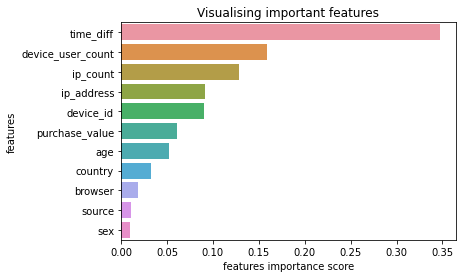

In [41]:
plt.title('Visualising important features')
plt.xlabel('features importance score')
plt.ylabel('features')
sns.barplot(x = feature_importances_, y = feature_importances_.index)

### Afficher le `Classification report`

In [42]:
print( classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34215
           1       0.99      0.54      0.70      3563

    accuracy                           0.96     37778
   macro avg       0.97      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



### Traçer la courbe AUC 

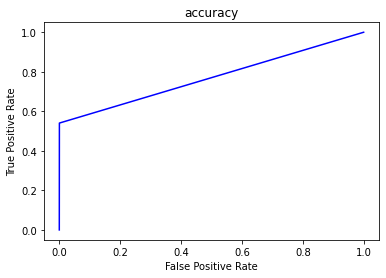

In [43]:
prob_score = clf_forest.predict_proba(X_test)
prob_score = DataFrame(prob_score).iloc[:,0]
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
#auc = auc(fpr,tpr)
#Plotting the accuracy
plt.plot(fpr,tpr, color = 'blue')
plt.title('accuracy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Afficher la matrice de confusion 
Qu'en pensez vous ? 

<AxesSubplot:>

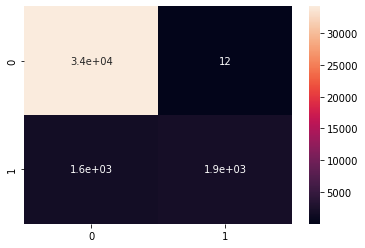

In [44]:
c = confusion_matrix(y_test, y_pred)
sns.heatmap(c,annot = True)

### Faire une selection de certaine variables et spliter vos varibales 

In [55]:
#features
X1= data_fraud[[
       'country','time_diff','ip_count', 'device_user_count']]
X1['country'] = lb.fit_transform(X['country'].astype(str))
#Response Variable
y1 = data_fraud['class']
#Splitting data into train and test dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size = 0.3, random_state= 42)
print("Shape du dataset d'entrainement : ",X_train1.shape,"| shape du dataset de test:", y_test1.shape)

Shape du dataset d'entrainement :  (105778, 4) | shape du dataset de test: (45334,)


### Entrainer un classifieur `LogisticRegression` sur ces variables 

In [56]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   country            151112 non-null  int32  
 1   time_diff          151112 non-null  float64
 2   ip_count           151112 non-null  int64  
 3   device_user_count  151112 non-null  int64  
dtypes: float64(1), int32(1), int64(2)
memory usage: 4.0 MB


In [61]:
cl_Logistic = LogisticRegression()
cl_Logistic.fit(X_train1, y_train1)

LogisticRegression()

### Afficher le Classification report

In [73]:
y_pred = cl_Logistic.predict(X_test1)
y_pred
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41117
           1       0.00      0.00      0.00      4217

    accuracy                           0.91     45334
   macro avg       0.45      0.50      0.48     45334
weighted avg       0.82      0.91      0.86     45334

